In [1]:
import os
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:
def lenet(input_shape, num_classes):
    model = Sequential()

    # extract image features by convolution and max pooling layers
    model.add(Conv2D(
        20, kernel_size=5, padding="same",
        input_shape=input_shape, activation="relu"
        ))
    # 20 : フィルターを20個使用
    # kernel_size=5 : 5 * 5のフィルター
    # padding="same" : 出力する特徴マップのサイズは入力データと同じサイズになるように自動でpaddingが設定される
    # activation="relu" : 使用する活性化関数はReLU
    # MNISTの場合出力サイズは　28 * 28 * 20
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 出力サイズは 14 * 14 * 20
    
    model.add(Conv2D(50, kernel_size=5, padding="same", activation="relu"))
    # 出力サイズは　14 * 14 * 50
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 出力サイズは　7 * 7 * 50
    
    # classify the class by fully-connected layers
    model.add(Flatten())
    # 特徴マップをベクトルに変換
    
    model.add(Dense(500, activation="relu"))
    model.add(Dense(num_classes))
    model.add(Activation("softmax"))
    return model

In [3]:
class MNISTDataset():

    def __init__(self):
        self.image_shape = (28, 28, 1)  # image is 28x28x1 (grayscale)
        self.num_classes = 10

    def get_batch(self):
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        x_train, x_test = [self.preprocess(d) for d in [x_train, x_test]]
        y_train, y_test = [self.preprocess(d, label_data=True) for d in
                           [y_train, y_test]]

        return x_train, y_train, x_test, y_test
    
    def preprocess(self, data, label_data=False):
        if label_data:
            # convert class vectors to binary class matrices
            data = keras.utils.to_categorical(data, self.num_classes)
        else:
            data = data.astype("float32")
            data /= 255  # convert the value to 0~1 scale
            shape = (data.shape[0],) + self.image_shape  # add dataset length
            data = data.reshape(shape)

        return data
    

In [4]:
class Trainer():

    def __init__(self, model, loss, optimizer):
        self._target = model
        self._target.compile(
            loss=loss, optimizer=optimizer, metrics=["accuracy"]
            )
        self.verbose = 1
        logdir = "logdir_lenet"
        self.log_dir = os.path.join(os.path.dirname('__file__'), logdir)

    def train(self, x_train, y_train, batch_size, epochs, validation_split):
        if os.path.exists(self.log_dir):
            import shutil
            shutil.rmtree(self.log_dir)  # remove previous execution
        os.mkdir(self.log_dir)

        self._target.fit(
            x_train, y_train,
            batch_size=batch_size, epochs=epochs,
            validation_split=validation_split,
            callbacks=[TensorBoard(log_dir=self.log_dir)],
            verbose=self.verbose
        )


In [5]:
#フィルターの可視化をする関数
def plot_conv_weights(filters):
    filter_num = filters.shape[3]
    
    for i in range(filter_num):
        plt.subplot(filter_num/6 + 1, 6, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'filter {i}')
        plt.imshow(filters[:, :, 0, i])
        plt.gray()

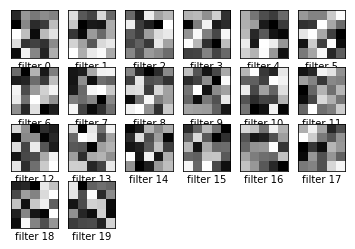

In [6]:
dataset = MNISTDataset()

# make model
model = lenet(dataset.image_shape, dataset.num_classes)
plot_conv_weights(model.layers[0].get_weights()[0])


In [7]:
# train the model
x_train, y_train, x_test, y_test = dataset.get_batch()
trainer = Trainer(model, loss="categorical_crossentropy", optimizer=Adam())
trainer.train(
    x_train, y_train, batch_size=128, epochs=12, validation_split=0.2
    )

# show result
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 5s 103us/step - loss: 0.1807 - accuracy: 0.9456 - val_loss: 0.0594 - val_accuracy: 0.9815
Epoch 2/12
48000/48000 [==============================] - 3s 71us/step - loss: 0.0476 - accuracy: 0.9853 - val_loss: 0.0457 - val_accuracy: 0.9869
Epoch 3/12
48000/48000 [==============================] - 3s 71us/step - loss: 0.0305 - accuracy: 0.9906 - val_loss: 0.0356 - val_accuracy: 0.9891
Epoch 4/12
48000/48000 [==============================] - 3s 71us/step - loss: 0.0237 - accuracy: 0.9924 - val_loss: 0.0393 - val_accuracy: 0.9886
Epoch 5/12
48000/48000 [==============================] - 3s 71us/step - loss: 0.0166 - accuracy: 0.9941 - val_loss: 0.0365 - val_accuracy: 0.9902
Epoch 6/12
48000/48000 [==============================] - 3s 71us/step - loss: 0.0145 - accuracy: 0.9952 - val_loss: 0.0365 - val_accuracy: 0.9902
Epoch 7/12
48000/48000 [==============================] - 3s 71us/s

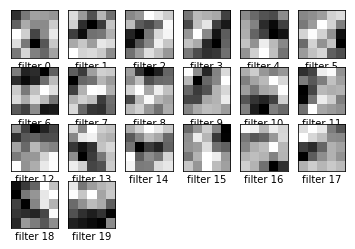

In [8]:
plot_conv_weights(model.layers[0].get_weights()[0])